<a id="toc"></a>
# DEIMOS beamline simulation with PyOptiX
***

Contents :
1. [Optical elements declaration](#def_opt)
1. [Definition of optical parameters](#def_param)
1. [Alignment scripts](#alignement)
1. [Simulation execution](#exec)
1. [Visualisation](#visu)
1. [Monochromator resolution](#monores)

In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '21/OCT/2024'
__changed__ = '28/OCT/2024'


import ctypes

import numpy as np
import pandas as pd
import pyoptix
import pyoptix.classes as opx
from barc4xoc.aux_pyoptix import read_beam_from_csv, save_beam_to_csv
from barc4xoc.misc import coddington_equations
from scipy.constants import c, degree, eV, h, micro, milli, nano, pi, pico

hc = h*c/eV

pyoptix.set_aperture_active(False)
pyoptix.output_notebook()


OptiX library initialized


Loading BokehJS ...

<a id="def_opt"></a>
## Optical elements declaration
[Back to the top](#toc)

In [2]:
Deimos = opx.Beamline(name="Deimos - current")

# ------------------
# source
# ------------------
undulator_U52 = opx.UndulatorSource(name="U52")         # HU52 - 350eV - 2500eV
undulator_U65 = opx.UndulatorSource(name="U65")         # EMPHU65 - same energy range, but 1.8m downstream
undulator_SII = opx.UndulatorSource(name="SII")         # HU52 - 350eV - 2500eV with SOLEIL-II magnetic lattice

# ------------------
# optical elements
# ------------------
pupil = opx.PlaneFilm(name="pupil")

# M1
m1a = opx.PlaneMirror(name="M1A")
m1b = opx.ToroidalMirror(name="M1B")
m1c = opx.ToroidalMirror(name="M1C")

# monochromator
# grating_1600 = opx.PlaneHoloGrating(name="grating_1600")   # VGD
grating_1600 = opx.PlaneGrating(name="grating_1600")       
grating_2400 = opx.PlaneGrating(name="grating_2400")       # MCA

m2 = opx.PlaneMirror(name="M2")
m3 = opx.CylindricalMirror(name="M3")
foc_hor = opx.PlaneFilm(name="mono_foc_hor")
mono_exit_slit = opx.PlaneFilm(name="mono_foc_ver")

# M4
# m4a = opx.ToroidalMirror(name="M4A")
# m4b = opx.ToroidalMirror(name="M4B")
m4a = opx.ConicCylindricalMirror(name="M4A")
m4b = opx.ConicCylindricalMirror(name="M4B")

# M5
# m5a = opx.ToroidalMirror(name="M5A")
# m5b = opx.ToroidalMirror(name="M5B")
m5a = opx.ConicCylindricalMirror(name="M5A")
m5b = opx.ConicCylindricalMirror(name="M5B")

# ------------------
# endstations
# ------------------
cromag = opx.PlaneFilm(name="cromag")
mk2t = opx.PlaneFilm(name="mk2t")

In [3]:
undulators = [undulator_U52, undulator_U65, undulator_SII]
m1 = [m1b, m1c]
gratings = [grating_1600, grating_2400]
wolters = [[m4a, m5a], [m4b, m5b], []]
endstations = [cromag, mk2t]

for undulator in undulators:
    for m1bis in m1:
        for grating in gratings:
            # beamline = [undulator, pupil, m1a, m1bis, grating, m2, m3, foc_hor, mono_exit_slit]        
            beamline = [undulator, pupil, m1a, m1bis, grating, m2, m3, mono_exit_slit]           
   
            for focusing in wolters:
                if len(focusing) > 1:
                    chain_name = f"{undulator.name}_{m1bis.name}_G{grating.name.split('_')[1]}_WLT_{focusing[-2].name[-1]}"
                    Deimos.chains[chain_name] = beamline + focusing + endstations
                else:
                    chain_name = f"{undulator.name}_{m1bis.name}_G{grating.name.split('_')[1]}_mono"
                    Deimos.chains[chain_name] = beamline


In [4]:
print("Low energy configurations:\n")
for chain_name in Deimos.chains:    
    if "M1B" in chain_name:
        print(chain_name,":\n\t",Deimos.chains[chain_name])

Low energy configurations:

U52_M1B_G1600_WLT_A :
	 U52 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1B_G1600_WLT_B :
	 U52 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1B_G1600_mono :
	 U52 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver 
U52_M1B_G2400_WLT_A :
	 U52 -> pupil -> M1A -> M1B -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1B_G2400_WLT_B :
	 U52 -> pupil -> M1A -> M1B -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1B_G2400_mono :
	 U52 -> pupil -> M1A -> M1B -> grating_2400 -> M2 -> M3 -> mono_foc_ver 
U65_M1B_G1600_WLT_A :
	 U65 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U65_M1B_G1600_WLT_B :
	 U65 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U65_M1B_G1600_

In [5]:
print("High energy configurations:\n")
for chain_name in Deimos.chains:    
    if "M1C" in chain_name:
        print(chain_name,":\n\t",Deimos.chains[chain_name])

High energy configurations:

U52_M1C_G1600_WLT_A :
	 U52 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1C_G1600_WLT_B :
	 U52 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1C_G1600_mono :
	 U52 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver 
U52_M1C_G2400_WLT_A :
	 U52 -> pupil -> M1A -> M1C -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1C_G2400_WLT_B :
	 U52 -> pupil -> M1A -> M1C -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1C_G2400_mono :
	 U52 -> pupil -> M1A -> M1C -> grating_2400 -> M2 -> M3 -> mono_foc_ver 
U65_M1C_G1600_WLT_A :
	 U65 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U65_M1C_G1600_WLT_B :
	 U65 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U65_M1C_G1600

<a id="def_param"></a>
## Definition of optical parameters

In this section we define the static parameters of the optical elements. Characteristics that change with 
either configuration or energy are defined in the [Alignment scripts](#alignement) section.

[Back to the top](#toc)

In [6]:
electron_parameters = pd.read_csv(r"./resources/2023-04-26-Dimensions-SOLEIL-actuel-pour-Stephane-BAC.csv", delimiter=";")
electron_parameters.loc[electron_parameters['BeamLineName'].str.contains('DEIMOS')]

,BeamLineName,Long_Pos(m),RMS_H_Size(µm),RMS_V_Size(µm),RMS_H_div(µrad),RMS_V_div(µrad),betaX(m),betaZ(m),etax(m),etaxp(-),etaz(m),etazp(-),alphax(-),alphaz(-)
21,DEIMOS_1,132.4453,206.5,8.0,31.6,4.0,3.9210,2.1191,0.1632,0.0015,-0.0046,0.0018,0.0514,0.1430
22,DEIMOS_2,134.4113,216.2,9.7,31.6,4.0,4.7073,3.4180,0.1660,0.0015,-0.0011,0.0018,-0.4513,-0.8037


### HU52 undulator

In [7]:
src_name = "DEIMOS_1" # centre of straight section

e_beam = opx.ElectronBeam()
e_beam.from_twiss(energy=2.75, energy_spread=0.1025/100, current=0.500,
                  emittance=3.94*nano, coupling=1/100,
                  beta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaX(m)"].iloc[0]), 
                  eta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etax(m)"].iloc[0]), 
                  etap_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaxp(-)"].iloc[0]), 
                  alpha_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphax(-)"].iloc[0]),
                  beta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaZ(m)"].iloc[0]), 
                  eta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaz(m)"].iloc[0]), 
                  etap_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etazp(-)"].iloc[0]), 
                  alpha_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphaz(-)"].iloc[0]))
e_beam.print_rms()

hu52 = opx.MagneticStructure(period_length=52.4e-3, number_of_periods=30)

undulator_U52.electron_beam = e_beam
undulator_U52.magnetic_structure = hu52

undulator_U52.write_syned_config(r".\resources\oasys_soleil_hu52","Soleil - HU52")

electron beam:
            >> x/xp = 208.03 um vs. 31.62 urad
            >> y/yp = 10.24 um vs. 4.71 urad


### HU65 undulator

In [8]:
src_name = "DEIMOS_2" # centre of straight section

e_beam = opx.ElectronBeam()
e_beam.from_twiss(energy=2.75, energy_spread=0.1025/100, current=0.500,
                  emittance=3.94*nano, coupling=1/100,
                  beta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaX(m)"].iloc[0]), 
                  eta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etax(m)"].iloc[0]), 
                  etap_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaxp(-)"].iloc[0]), 
                  alpha_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphax(-)"].iloc[0]),
                  beta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaZ(m)"].iloc[0]), 
                  eta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaz(m)"].iloc[0]), 
                  etap_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etazp(-)"].iloc[0]), 
                  alpha_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphaz(-)"].iloc[0]))
e_beam.print_rms()

emphu65 = opx.MagneticStructure(period_length=65e-3, number_of_periods=24)

undulator_U65.electron_beam = e_beam
undulator_U65.magnetic_structure = emphu65

undulator_U65.write_syned_config(r".\resources\oasys_soleil_emphu65","Soleil - EMPHU65")

electron beam:
            >> x/xp = 217.52 um vs. 31.62 urad
            >> y/yp = 11.60 um vs. 4.71 urad


### SOLEIL-II lattice (HU52 undulator)

In [9]:
e_beam = opx.ElectronBeam()
e_beam.from_twiss(energy=2.75, energy_spread=0.0906/100, current=0.500,
                  emittance_x=84.55*pico, emittance_y=25.36*pico,
                  beta_x=1.59, eta_x=0, etap_x=0, alpha_x=0,
                  beta_y=1.51, eta_y=0, etap_y=0, alpha_y=0)
e_beam.print_rms()

hu52 = opx.MagneticStructure(period_length=52.4e-3, number_of_periods=30)

undulator_SII.electron_beam = e_beam
undulator_SII.magnetic_structure = hu52

undulator_SII.write_syned_config(r".\resources\oasys_soleil-II_hu52","Soleil-II - HU52")

electron beam:
            >> x/xp = 11.59 um vs. 7.29 urad
            >> y/yp = 6.19 um vs. 4.10 urad


### Entrance pupil
[Back to the top](#toc)

In [10]:
pupil.distance_from_previous = 21
pupil.recording_mode = opx.RecordingMode.recording_output
pupil.next = m1a

### M1

[Back to the top](#toc)

In [11]:
old_m1_grazing_angles = [2.53*degree, 1.19*degree]

old_m1_distances = opx.M1_triad_distances(incident_angle=old_m1_grazing_angles,
                                          transverse_distance=41e-3, 
                                          verbose=1)

Distance from M1B to M1A: 464.858 mm
- proj. dist. into the optical axis: 463.047 mm

Distance from M1C to M1A: 987.312 mm
- proj. dist. into the optical axis: 986.460 mm



In [12]:
m1_grazing_angles = [1.75*degree, 0.75*degree]

m1_distances = opx.M1_triad_distances(incident_angle=m1_grazing_angles,
                                      transverse_distance=41e-3, 
                                      verbose=1)

Distance from M1B to M1A: 671.597 mm
- proj. dist. into the optical axis: 670.344 mm

Distance from M1C to M1A: 1566.264 mm
- proj. dist. into the optical axis: 1565.727 mm



#### - M1A

In [13]:
m1a.distance_from_previous = 0
m1a.phi = -90*degree # rad
m1a.recording_mode = opx.RecordingMode.recording_output

#### - M1B

In [14]:
p = pupil.distance_from_previous + m1_distances[0][0]
qminor = 1E23
qmajor = (m1_distances[1][1]-m1_distances[0][1]) + 5 + 0.7 + 4 # we focus on the mochromator slit

rminor = coddington_equations(m1_grazing_angles[0]/degree, p=p, q=qminor)["R"][1]
rmajor = coddington_equations(m1_grazing_angles[0]/degree, p=p, q=qmajor)["R"][0]

print("Toroidal mirror with side-bounce reflection:")
print(f"- source at {p:.3e} m")
print(f"- (sagittal) image at {qminor:.3} m")
print(f"- (meridional/tangential) image at {qmajor:.3e} m")

print("\nApplying the Coddington equations:")
print(f"- minor (sagittal) radius {rminor:.3e} m")
print(f"- major (meridional/tangential) radius {rmajor:.3e} m")

m1b.distance_from_previous = m1_distances[0][0]
m1b.theta = m1_grazing_angles[0] # rad
m1b.phi = 180*degree # rad
m1b.minor_curvature = 1/rminor # m-1   # m1b.minor_curvature = 1/1.894 # m-1
m1b.major_curvature = 1/rmajor # m-1   # m1b.major_curvature = 1/228.0 # m-1
m1b.recording_mode = opx.RecordingMode.recording_output
# m1b.next = grating_1600

Toroidal mirror with side-bounce reflection:
- source at 2.167e+01 m
- (sagittal) image at 1e+23 m
- (meridional/tangential) image at 1.060e+01 m

Applying the Coddington equations:
- minor (sagittal) radius 1.324e+00 m
- major (meridional/tangential) radius 4.660e+02 m


#### - M1C

In [15]:
p = pupil.distance_from_previous + m1_distances[1][0]
qminor = 1E23
qmajor = 5 + 0.7 + 4 # we focus on the mochromator slit

rminor = coddington_equations(m1_grazing_angles[1]/degree, p=p, q=qminor)["R"][1]
rmajor = coddington_equations(m1_grazing_angles[1]/degree, p=p, q=qmajor)["R"][0]

print("Toroidal mirror with side-bounce reflection:")
print(f"- source at {p:.3e} m")
print(f"- (sagittal) image at {qminor:.3e} m")
print(f"- (meridional/tangential) image at {qmajor:.3e} m")

print("\nApplying the Coddington equations:")
print(f"- minor (sagittal) radius {rminor:.3e} m")
print(f"- major (meridional/tangential) radius {rmajor:.3e} m")

m1c.distance_from_previous = m1_distances[1][0]
m1c.theta = m1_grazing_angles[1] # rad
m1c.phi = 180*degree # rad
m1c.minor_curvature = 1/rminor   # m-1   # m1c.minor_curvature = 1/0.91  # m-1
m1c.major_curvature = 1/rmajor   # m-1   # m1c.major_curvature = 1/455   # m-1
m1c.recording_mode = opx.RecordingMode.recording_output

# m1b.next = grating_2400

Toroidal mirror with side-bounce reflection:
- source at 2.257e+01 m
- (sagittal) image at 1.000e+23 m
- (meridional/tangential) image at 9.700e+00 m

Applying the Coddington equations:
- minor (sagittal) radius 5.908e-01 m
- major (meridional/tangential) radius 1.037e+03 m


### Monochromator

[Back to the top](#toc)

#### Grating 1600 l/mm

In [16]:
# grating_1600.distance_from_previous = 5.0
# grating_1600.line_density = 1600/milli
# grating_1600.from_solemio(1e-10, 1e-10, 0.7660444, -0.56176)     # RC20240502 - where did you get this?
# grating_1600.order_align = 1 
# grating_1600.order_use = 1 
# grating_1600.phi = -90*degree
# grating_1600.recording_mode = opx.RecordingMode.recording_output
# grating_1600.next = m2
# grating_1600.show_vls_law(300e-3,3)

grating_1600.distance_from_previous = 5.0
grating_1600.line_density = 1600/milli
grating_1600.phi = -90*degree
grating_1600.order_align = 1
grating_1600.order_use = 1
grating_1600.recording_mode = opx.RecordingMode.recording_output
grating_1600.next = m2

#### Grating 2400 l/mm

In [17]:
grating_2400.distance_from_previous = 5.0
grating_2400.line_density = 2400/milli
grating_2400.phi = -90*degree
grating_2400.order_align = 1
grating_2400.order_use = 1
grating_2400.recording_mode = opx.RecordingMode.recording_output
grating_2400.next = m2

#### M2

In [18]:
m2.phi = 180*degree
m2.recording_mode = opx.RecordingMode.recording_output
m2.next = m3

#### M3 - vertical deflection

In [19]:
p = 1E23
qminor = 1E23
qmajor = 4

rminor = coddington_equations(0.44, p=p, q=qminor)["R"][1]
rmajor = coddington_equations(0.44, p=p, q=qmajor)["R"][0]

print("Toroidal mirror with bounce-up reflection:")
print(f"- source at {p:.3e} m")
print(f"- (sagittal) image at {qminor:.3e} m")
print(f"- (meridional/tangential) image at {qmajor:.3e} m")

print("\nApplying the Coddington equations:")
print(f"- minor (sagittal) radius {rminor:.3e} m")
print(f"- major (meridional/tangential) radius {rmajor:.3e} m")


m3.theta = 0.44*degree # rad
m3.phi = 180*degree    # rad
m3.curvature = 1/rmajor  # m-1
m3.axis_angle = 0*degree # tangential cylinder 
m3.recording_mode = opx.RecordingMode.recording_output
m3.next = mono_exit_slit

Toroidal mirror with bounce-up reflection:
- source at 1.000e+23 m
- (sagittal) image at 1.000e+23 m
- (meridional/tangential) image at 4.000e+00 m

Applying the Coddington equations:
- minor (sagittal) radius 7.679e+20 m
- major (meridional/tangential) radius 1.042e+03 m


#### M3 - horizontal deflection

In [20]:
# p = 1E23
# qminor = 4
# qmajor = 1E23

# rminor = coddington_equations(0.44, p=p, q=qminor)["R"][1]
# rmajor = coddington_equations(0.44, p=p, q=qmajor)["R"][0]

# print("Toroidal mirror with side-bounce reflection:")
# print(f"- source at {p:.3e} m")
# print(f"- (sagittal) image at {qminor:.3e} m")
# print(f"- (meridional/tangential) image at {qmajor:.3e} m")

# print("\nApplying the Coddington equations:")
# print(f"- minor (sagittal) radius {rminor:.3e} m")
# print(f"- major (meridional/tangential) radius {rmajor:.3e} m")

# m3.theta = 0.44*degree # rad
# m3.phi = 90*degree    # rad
# m3.curvature = 1/rminor  # m-1
# m3.axis_angle = 90*degree # tangential cylinder 
# m3.recording_mode = opx.RecordingMode.recording_output
# m3.next = mono_exit_slit
# mono_exit_slit.phi = 90*degree # rad


#### Horizontal focusing

In [21]:
foc_hor.distance_from_previous = 0
foc_hor.phi = 0*degree # rad
foc_hor.recording_mode = opx.RecordingMode.recording_output
foc_hor.next = mono_exit_slit

### Mono exit slits

In [22]:
mono_exit_slit.distance_from_previous = 3.8 + 0.2
mono_exit_slit.phi = 0*degree # rad
# mono_exit_slit.add_rectangular_stop(20*micro, 20*micro, opacity=0)
mono_exit_slit.recording_mode = opx.RecordingMode.recording_output

### Focusing optics

[Back to the top](#toc)

The centre of the current Wolter system is at $5.5 + 0. 2$ m from the mono exit slit. The focusing is at $3$ m downstream (KB-A) and at 
$3+1.76$ m downstream (KB-B). This is the minimal distance between stations, but not the largest.

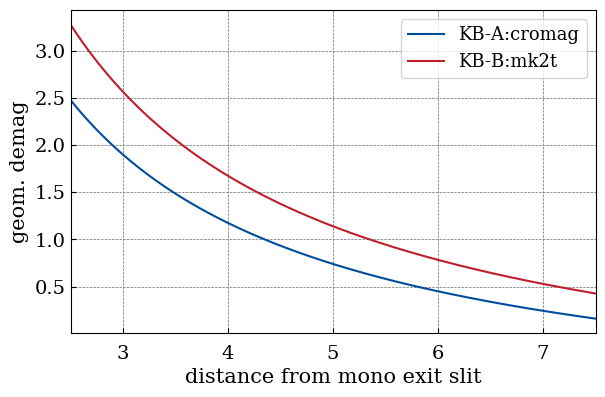

In [23]:
from barc4plots.barc4plots import PlotManager

pi, pf = 2.5, 7.5
p = np.linspace(pi, pf, 1001)

sep = 2
arm = 5.5+0.2+3
q1 = arm-p
q2 = arm+sep-p

fig = PlotManager()

fig.image, fig.x = q1/p, p
fig.additional_info(None, "distance from mono exit slit", "geom. demag").aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'KB-A:cromag').plot_1d(enable=False)
fig.image, fig.x =  q2/p, p
fig.info_1d_plot(1, 'KB-B:mk2t').plot_1d(enable=True, hold=True)

In [24]:
dfp = 5.5
dist_KB_pair = 0.4
arm = 4.
sep = 2.

#### M4A (KB horizontal focusing)

In [25]:
# m4a.distance_from_previous = dfp - dist_KB_pair/2
# m4a.theta = 0.44*degree
# m4a.phi = 180*degree
# m4a.inverse_p = -1/(m4a.distance_from_previous)
# m4a.inverse_q = 1/(arm + dist_KB_pair/2)
# m4a.theta0 = m4a.theta
# m4a.recording_mode = opx.RecordingMode.recording_output
# m4a.next = m5a

m4a.distance_from_previous = dfp - dist_KB_pair/2
m4a.theta = 0.44*degree
m4a.phi = -90*degree
m4a.inverse_p = -1/(m4a.distance_from_previous)
m4a.inverse_q = 1/(arm + dist_KB_pair/2)
m4a.theta0 = m4a.theta
m4a.recording_mode = opx.RecordingMode.recording_output
m4a.next = m5a

#### M4B (KB - horizontal focusing)

In [26]:
# m4b.distance_from_previous = 5.5
# m4b.theta = 1.2*degree
# m4b.phi = 90*degree
# m4b.minor_curvature = 1/0.3761 # m-1
# m4b.major_curvature = 1/347.3 # m-1
# m5a.recording_mode = opx.RecordingMode.recording_output
# m4b.next = m5b 

#### M5A (KB - vertical focusing)

In [27]:
# m5a.distance_from_previous = dist_KB_pair
# m5a.theta = 0.44*degree
# m5a.phi = -90*degree
# m5a.inverse_p = -1/(m4a.distance_from_previous + dist_KB_pair)
# m5a.inverse_q = 1/(arm - dist_KB_pair/2)
# m5a.theta0 = m5a.theta
# m5a.recording_mode = opx.RecordingMode.recording_output
# m5a.next = cromag
m5a.distance_from_previous = dist_KB_pair
m5a.theta = 0.44*degree
m5a.phi = 90*degree
m5a.inverse_p = -1/(m4a.distance_from_previous + dist_KB_pair)
m5a.inverse_q = 1/(arm - dist_KB_pair/2)
m5a.theta0 = m5a.theta
m5a.recording_mode = opx.RecordingMode.recording_output
m5a.next = cromag

### M5B-E

In [28]:
# m5b.distance_from_previous = 0.4
# m5b.theta = 1.2*degree
# m5b.minor_curvature = 1/0.15   # m-1
# m5b.major_curvature = 1/3000.0 # m-1
# m5b.recording_mode = opx.RecordingMode.recording_output
# m5b.next = cromag 

### Endstations

[Back to the top](#toc)

#### CroMag

In [29]:
# cromag.distance_from_previous = arm - dist_KB_pair/2 # m
# cromag.phi =-90*degree
# cromag.recording_mode = opx.RecordingMode.recording_output
# cromag.next = mk2t
cromag.distance_from_previous = arm - dist_KB_pair/2 # m
cromag.phi =0*degree
cromag.recording_mode = opx.RecordingMode.recording_output
cromag.next = mk2t

#### mK2T

In [30]:
mk2t.distance_from_previous = sep
mk2t.phi = 0
mk2t.recording_mode = opx.RecordingMode.recording_output

<a id="alignement"></a>
## Alignment scripts

In this section we define the all the parameters that change with either configuration or energy. These scripts are tailored
for each 

[Back to the top](#toc)

### Undulators

In [31]:
def align_undulator(active_chain, wavelength, **kwargs):
    """
    Sets photon beam size and divergence as a function of wavelength in [m]
    """

    verbose = kwargs.get("verbose", False)
    dist_slit = kwargs.get("dist_slit", 21)
    
    if verbose:
        print("\n>>>> Aligning undulator")

    active_chain[0].set_undulator(wavelength, **kwargs)
    active_chain[1].distance_from_previous = dist_slit
    if "65" in active_chain[0].name:
        active_chain[1].distance_from_previous -= (
            float(electron_parameters[electron_parameters.BeamLineName == "DEIMOS_2"]["Long_Pos(m)"].iloc[0])-
            float(electron_parameters[electron_parameters.BeamLineName == "DEIMOS_1"]["Long_Pos(m)"].iloc[0])
        )


### M1 

In [32]:
def align_m1(active_chain, m1_distances, **kwargs):
    """
    Sets the M1A angle and distance from mono first optical element to M1bis
    """
    
    dist_next = kwargs.get("dist_next", 5)
    verbose = kwargs.get("verbose", False)

    if verbose:
        print("\n>>>> Aligning M1")
   
    active_chain[2].theta = active_chain[3].theta
    active_chain[2].next  = active_chain[3]
    active_chain[3].next = active_chain[4]
    active_chain[4].distance_from_previous = dist_next

    if "1B" in active_chain[3].name:
        active_chain[4].distance_from_previous += (m1_distances[1][1]-m1_distances[0][1])       

    if verbose:
        name = active_chain[3].name
        angle = active_chain[3].theta/degree
        dist = active_chain[3].distance_from_previous
        print(f"M1A-{name} alignment: grazing angle {angle:.2f} degrees and {dist:.3f} m between them")

### Monochromator 

In [33]:
def align_mono(active_chain, wavelength, alignment_condition, alignment_condition_value,
               GM2_trans_dist, GM3_proj_dist, **kwargs):
    """
    Sets the grating and M2 angles and relative distances between G/M2/M3
    """

    verbose = kwargs.get("verbose", False)

    grating = None
    for count, oe in enumerate(active_chain):
        if "reseau" in oe.name.lower() or "grating" in oe.name.lower():
            grating = oe
            mono_oe_pos = count

    if grating is None:
        raise ValueError("No grating appears in this beamline configuration")
    
    gdict = opx.align_grating(grating, verbose=0, 
                             apply_alignment=True, 
                             return_parameters=True,
                             condition=alignment_condition, 
                             condition_value=alignment_condition_value, 
                             lambda_align=wavelength, 
                             order=grating.order_align,
                             line_density=grating.line_density)
    
    gm2 = GM2_trans_dist/np.sin(gdict["deviation"])
    m2m3 = GM3_proj_dist-(GM2_trans_dist/np.tan(gdict["deviation"]))

    active_chain[int(mono_oe_pos+1)].theta = gdict["deviation"]/2
    active_chain[int(mono_oe_pos+1)].distance_from_previous = gm2 

    active_chain[int(mono_oe_pos+2)].distance_from_previous = m2m3

    if verbose:
        if alignment_condition == 'omega':
            alignment_condition_str =f"{alignment_condition_value/degree :.3f}"
        else:
            alignment_condition_str =alignment_condition_value
        print(f"\n>>>> {grating.name} grating alignment for "+
              f"{alignment_condition} {alignment_condition_str} - wavelength " +
              f"{wavelength/nano:.3f} nm (E={hc/wavelength:.3f} eV)")
        print(f"> alpha {gdict['alpha_deg']:.6f} deg")
        print(f"> beta {gdict['beta_deg']:.6f} deg")
        if alignment_condition == 'omega':
            cff_value = np.sin(gdict['beta'])/np.sin(gdict['alpha'])
            print(f">> cff {cff_value:.2f}")
        print(f"> G-M2 distance {gm2:.6f} m")
        print(f"> theta_m2 {(gdict['alpha_deg']+gdict['beta_deg'])/2:.6f} deg")
        print(f"> M2-M3 distance {m2m3:.6f} m")

### Beamline alignment procedure

In [34]:
def align_call(alignment_wvl, emission_wvl, alignment_condition, alignment_condition_value, 
               m1_distances, GM2_trans_dist, GM3_proj_dist, **kwargs):

    align_undulator(Deimos.active_chain, emission_wvl, **kwargs)
    align_m1(Deimos.active_chain, m1_distances, **kwargs)
    align_mono(Deimos.active_chain, alignment_wvl, alignment_condition, 
               alignment_condition_value, GM2_trans_dist, GM3_proj_dist, **kwargs)
    
Deimos.align_steps = align_call

def set_bl(energy_alignment, alignment_condition, alignment_condition_value, 
               m1_distances=m1_distances, GM2_trans_dist=20e-3, GM3_proj_dist=700e-3, **kwargs):

    energy_radiate =  kwargs.get("energy_radiate", energy_alignment)
    dE =  kwargs.get("dE", 0)
    rays = kwargs.get("rays", 500)

    alignment_wvl = hc/energy_alignment
    emission_wvl = hc/energy_radiate

    Deimos.align(alignment_wvl, emission_wvl, 
                 alignment_condition=alignment_condition, 
                 alignment_condition_value=alignment_condition_value, 
                 m1_distances=m1_distances, GM2_trans_dist=GM2_trans_dist,
                 GM3_proj_dist=GM3_proj_dist, **kwargs)

    Deimos.clear_impacts(clear_source=True)
    Deimos.active_chain[0].nrays = rays
    if dE==0:
        Deimos.generate(emission_wvl)
    else:
        for E in np.arange(energy_radiate*(1-dE), energy_radiate*(1+dE)):
            Deimos.generate(hc/E)
    Deimos.radiate()

<a id="exec"></a>
## Simulation execution
[Back to the top](#toc)

### Available beamline configurations

In [35]:
print("Low energy configurations:")
for chain_name in Deimos.chains:    
    if "M1B" in chain_name:
        print(chain_name,":\n\t",Deimos.chains[chain_name])

Low energy configurations:
U52_M1B_G1600_WLT_A :
	 U52 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1B_G1600_WLT_B :
	 U52 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1B_G1600_mono :
	 U52 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver 
U52_M1B_G2400_WLT_A :
	 U52 -> pupil -> M1A -> M1B -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1B_G2400_WLT_B :
	 U52 -> pupil -> M1A -> M1B -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1B_G2400_mono :
	 U52 -> pupil -> M1A -> M1B -> grating_2400 -> M2 -> M3 -> mono_foc_ver 
U65_M1B_G1600_WLT_A :
	 U65 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U65_M1B_G1600_WLT_B :
	 U65 -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U65_M1B_G1600_m

In [36]:
print("High energy configurations:")
for chain_name in Deimos.chains:    
    if "M1C" in chain_name:
        print(chain_name,":\n\t",Deimos.chains[chain_name])

High energy configurations:
U52_M1C_G1600_WLT_A :
	 U52 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1C_G1600_WLT_B :
	 U52 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1C_G1600_mono :
	 U52 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver 
U52_M1C_G2400_WLT_A :
	 U52 -> pupil -> M1A -> M1C -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U52_M1C_G2400_WLT_B :
	 U52 -> pupil -> M1A -> M1C -> grating_2400 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U52_M1C_G2400_mono :
	 U52 -> pupil -> M1A -> M1C -> grating_2400 -> M2 -> M3 -> mono_foc_ver 
U65_M1C_G1600_WLT_A :
	 U65 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 
U65_M1C_G1600_WLT_B :
	 U65 -> pupil -> M1A -> M1C -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4B -> M5B -> cromag -> mk2t 
U65_M1C_G1600_

The beamline can be conviniently simulated by selecting an **active chain** and an energy:

```python
Deimos.active_chain = "U52_M1B_G1600_mono"
set_bl(350, alignment_condition="cff", alignment_condition_value=0.2, verbose=True)
```

To check the orientation of the optical elements, draw the beamline:

```python
Deimos.show_active_chain_orientation()
Deimos.draw_active_chain()
spots = Deimos.draw_to_scale()
```

<a id="visu"></a>
# Visualisations 
[Back to the top](#toc)

In [37]:
rays = 5000
E = 350

### HU52 with 1600 l/mm grating - E=350 eV

[Back to the top](#toc)

In [38]:
Deimos.active_chain = "SII_M1B_G1600_WLT_A"
set_bl(E, alignment_condition="cff", alignment_condition_value=0.2, verbose=True, rays=rays, center_undulator=0)
Deimos.show_active_chain_orientation()

Chaîne SII_M1B_G1600_WLT_A:
	SII -> pupil -> M1A -> M1B -> grating_1600 -> M2 -> M3 -> mono_foc_ver -> M4A -> M5A -> cromag -> mk2t 

>>>> Aligning undulator
electron beam:
            >> x/xp = 11.59 um vs. 7.29 urad
            >> y/yp = 6.19 um vs. 4.10 urad
filament photon beam:
            >> u/up = 16.27 um vs. 32.75 urad
photon beam waist positon:
            >> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
            >> x/xp = 19.98 um vs. 33.56 urad
            >> y/yp = 17.41 um vs. 33.01 urad

>>>> Aligning M1
M1A-M1B alignment: grazing angle 1.75 degrees and 0.672 m between them

>>>> grating_1600 grating alignment for cff 0.2 - wavelength 3.542 nm (E=350.000 eV)
> alpha 6.228728 deg
> beta 1.243391 deg
> G-M2 distance 0.153794 m
> theta_m2 3.736060 deg
> M2-M3 distance 0.547512 m
SII ↑
pupil ↑
M1A →
M1B ←
grating_1600 ↑
M2 ↓
M3 ↑
mono_foc_ver ↑
M4A →
M5A ↑
cromag ↑
mk2t ↑


In [39]:
oe = cromag
f = opx.get_optimal_focalization_distance(oe, verbose=True)

Optimal focalization along X at -0.003 m from this plane
Optimal focalization along Y at -0.019 m from this plane


In [40]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [41]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False,) 

In [42]:
oe = mk2t
f = opx.get_optimal_focalization_distance(oe, verbose=True)

Optimal focalization along X at -2.011 m from this plane
Optimal focalization along Y at -2.051 m from this plane


In [43]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [44]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False,) 

In [ ]:
E = 350

Deimos.active_chain = "SII_M1B_G1600_mono"
set_bl(E, alignment_condition="cff", alignment_condition_value=0.2, verbose=True, rays=rays, center_undulator=0)

oe = mono_exit_slit
f = opx.get_optimal_focalization_distance(oe, verbose=True)
# f_name = f"./results/optix_up_{Deimos.active_chain_name}_@_{oe.name}_E{E}eV_vertical.csv"
# beam = save_beam_to_csv(oe.get_impacts(), f_name)


In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False,) 

#### Horizontal focusing slits

In [ ]:
oe = foc_hor
f = opx.get_optimal_focalization_distance(oe, verbose=True)

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False,) 

#### Mono exit slit

In [ ]:
oe = mono_exit_slit
f = opx.get_optimal_focalization_distance(oe, verbose=True)

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

### Endstations with M4A-M5A (Wolter A) pair

In [ ]:
Deimos.active_chain = "U52_G1600_WLT_A"
set_bl(E, alignment_condition="cff", alignment_condition_value=0.2, verbose=True, rays=rays, center_undulator=0)

#### cromag

In [ ]:
oe = cromag
f = opx.get_optimal_focalization_distance(oe, verbose=True)

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

#### mK2T

In [ ]:
oe = mk2t
f = opx.get_optimal_focalization_distance(oe, verbose=True)

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:

opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

#### Endstations with M4B-M5B pair

In [ ]:
Deimos.active_chain = "U52_G1600_WLT_B"
set_bl(E, alignment_condition="cff", alignment_condition_value=0.2, verbose=True, rays=rays, center_undulator=0)

#### cromag

In [ ]:
oe = cromag
f = opx.get_optimal_focalization_distance(oe, verbose=True)

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

#### mK2T

In [ ]:
oe = mk2t
f = opx.get_optimal_focalization_distance(oe, verbose=True)

In [ ]:
opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="X", y_key="dX", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

In [ ]:

opx.plot_spd_plotly(oe.get_diagram(distance_from_oe=0), oe_name=oe.name, x_key="Y", y_key="dY", 
                show_map=False, light_plot=False, orthonorm=False, save_in_file="", return_fwhm=False, ) 

<a id="monores"></a>
## Monochromator resolution 
[Back to the top](#toc)